# Проект №3. О вкусной и здоровой пище 

In [303]:
import pandas as pd
import numpy as np 
import re
import json
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import unicodedata #для транслитерации не ASCII
import unidecode #для транслитерации не ASCII 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [304]:
# Для переносимости кода, создаем requirements.txt
!pip freeze > requirements.txt

In [305]:
# Для воспроизводимости результатов зададим:
# - общий параметр для генерации случайных чисел
RANDOM_SEED = 20726
# - общую текущую дату
CURRENT_DATE = pd.to_datetime('22/02/2020')
#Путь к 'submission.csv'
submission_path = './data/kagle/submission.csv'

In [306]:
# Путь к датасету обучения и валидации
df_in = pd.read_csv('./data/kagle/main_task.csv')

In [307]:
# Путь к датасету для которого требуется предсказать рейтинг
df_kagle = pd.read_csv('./data/kagle/kaggle_task.csv')

In [308]:
# Путь к датасету стран - отсюда берем столицы
df_county = pd.read_csv('./data/kagle/country-list.csv')

In [309]:
#датасет по городам и странам
df_urb_xls = pd.read_excel('./data/kagle/global-city-population-estimates.xls', index_col=None, header=0, sheet_name = 'CITIES-OVER-300K')

In [310]:
# Размечаем датасеты на рабочий и для предсказания
df_kagle['ForTrain'] = False
df_in['ForTrain'] = True
df_in = pd.concat([df_in, df_kagle])

In [311]:
df_in = df_in.reset_index()

In [312]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

In [313]:
def round_of_rating(number):
    """
    Округляем до 0.5
    """
    return np.round(number * 2) / 2

In [314]:
def get_Weighed_Rank_RK(row):
    '''
    Вычисляем относительную позицию ресторана среди всех ресторанов города
    '''
    Weighed_Rank = row['Ranking'] / row['Restaurants Count']

    return Weighed_Rank

In [315]:
def rev_time_delta(reviews):
    '''
    Вычисляем время между review в днях
    '''
    if (pd.notna(reviews)):
        reviews_dt_list = get_reviews(reviews)['reviews_dt']
        if reviews_dt_list:
            return (max(reviews_dt_list) - min(reviews_dt_list)).days
        else:
            return dt.timedelta(days=3650).days
    else:
        return dt.timedelta(days=3650).days

In [316]:
def get_reviews(rev):
    '''
    Получаем review в виде:
    review['reviews_txt'][1] - list of reviews
    review['reviews_dt'][1] - list of reviews dates
    '''
    if  not pd.isna(rev): 
        rev = str(rev).replace("'",'"')
        rev = rev.replace('], [', '], "reviews_dt": [')
        rev = '{ "reviews_txt":' + rev + '}'
        rev = rev.replace('[[','[').replace(']]',']')
        d = json.loads(rev)

        d['reviews_dt'] = [dt.datetime.strptime(date, '%m/%d/%Y').date() if len(date.split('/')[2])==4 else dt.datetime.strptime(date, '%m/%d/%y').date() for date in d['reviews_dt']]
        return d
    else:
        return {}

In [317]:
def get_cuisines(cuisines):
    '''
    Получаем список кухонь в виде:
    cuisines[0] - list of cusines
    если был NaN, то возвращается 'Vegetarian Friendly' -как самая популярная
    '''
    if cuisines == 'NaN': return ['Vegetarian Friendly'] # 'Vegetarian Friendly' - самая популярная
    if  cuisines:
        cuisines = str(cuisines).replace("'",'"')
        return json.loads(cuisines)
    else:
        return ['Vegetarian Friendly']

In [318]:
allCusines = []
def cuisine_styles_count(row):
    '''
    Получаем количество кухонь
    '''
    global allCusines
    cusines = get_cuisines(row['Cuisine Style'])
    
    if row['Cuisine Style'] != 'NaN':    
        cusines = get_cuisines(row['Cuisine Style'])
        allCusines.extend(cusines)
        cuisines_count =len(cusines)
    else:
        cuisines_count = 1

    return cuisines_count

In [319]:
def cleanup_string(str_in):
    '''
    "Чистим" текст в review для последующй десериализации
    Пока текст в анализе не используется, не успел... 
    '''
    try:      
        #middle
        str = str_in.replace("', \"","⅞").replace("', '","⅞").replace("\", '","⅞").replace("\", \"","⅞")# ", 
        str = str.replace("\", \"\"","⅞").replace("\"\", '","⅞").replace("\", \'","⅞").replace("\"\", \'","⅞")
        str = str.replace("\', \'","⅞")
        #middle
        #left
        str = str.replace("[['","≤").replace("['","⅛")
        #left
        #right
        str = str.replace("']]","≥").replace("']","⅝")
        #right
        #cleanups
        str = str.replace('\'', ' ').replace('\"', ' ').replace('\'', ' ').replace('"', ' ')     
        str = str.replace("\\", " ").replace("[[`", "≤").replace('\'"', '\'').replace('\'\"', '\'')
        str = str.replace('"\'', '\'').replace('\"\'', '\'').replace("[''" ,"≤").replace("[\'\'" ,"≤")
        str = str.replace(', `', ", \'").replace('`, ', "\', ").replace('\'', ' ').replace('\"', ' ')
        str = str.replace('\'', ' ').replace('"', ' ')
        #cleanups
        #middle
        str = str.replace("⅞", "', '")
        #middle
        #left
        str = str.replace("≤", "[['").replace("⅛", "['").replace('[[ ', '[[ \'')
        #left
        #right
        str = str.replace("≥" ,"']]").replace("⅝", "']").replace(' ]', ' \']')
        str = str.replace(', nan]', '\', \'nan\']').replace('[nan, ', '[\'nan\', \'')
        #right
    except Exception:
        print('<----',str_in,'---->')
    return str

In [320]:
def get_city_population_and_country():
    '''
    Получаем популяцию по городам, а так же ISO код страны по городу (из внешних источников)
    '''
    population_city_dict = {}
    country_city_dict = {}
    cities = df["City"].unique()
    # Чистим названия городов от Unicode символов - транслитерацией
    df_urb_xls['Urban Agglomeration TL'] = df_urb_xls['Urban Agglomeration'].apply(lambda s: ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')) )
    df_urb_xls['Urban Agglomeration TL'] =  df_urb_xls['Urban Agglomeration'].apply(lambda x: unidecode.unidecode(x))

    for city in df["City"].unique(): #cities:
        vals = df_urb_xls[df_urb_xls['Urban Agglomeration TL'].str.contains(city)]['2015'].max()/1000
        vals = 0.3 if pd.isna(vals) else vals # т.к. в датасете города от 300тыс
        population_city_dict[city] = vals
        country = df_urb_xls[df_urb_xls['Urban Agglomeration TL'].str.contains(city)]['Country Code']
        country = -1 if country.shape[0] < 1 else country.values[0]
        country_city_dict[city] = country

    population_city_dict['Luxembourg'] = 0.613894 
    population_city_dict['Brussels'] = 2.115468 
    population_city_dict['Geneva'] = 0.686562 
    population_city_dict['Oporto'] = 0.214349 
    population_city_dict['Ljubljana'] = 0.279631

    country_city_dict['Luxembourg'] = 442 
    country_city_dict['Brussels'] = 56 
    country_city_dict['Geneva'] = 756 
    country_city_dict['Oporto'] = 620 
    country_city_dict['Ljubljana'] = 705
    return population_city_dict, country_city_dict

In [321]:
def get_capital_city_dict():
    capital_city_dict = {}
    cities =df["City"].unique()
    df_county['capital TL'] = df_county['capital'].apply(lambda s: ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')) )
    df_county['capital TL'] =  df_county['capital'].apply(lambda x: unidecode.unidecode(x))
    for city in cities:
        vals = df_county[df_county['capital TL'].str.contains(city)]['country'].shape[0]   
        vals = 0 if pd.isna(vals) or vals==0 else 1 
        capital_city_dict[city] = vals
    capital_city_dict['Barcelona'] = 1 # Страна Басков != Испания, дадим Барселоне статус мтолицы, но оставим в Испании 
    capital_city_dict['Zurich'] = 1 
    capital_city_dict['Geneva'] = 1 
    capital_city_dict['Oporto'] = 1 
    return capital_city_dict

In [322]:
def is_cuisine_top_N(cs):
    '''
    Возвращаем список кухонь, входящих в основной список кухонь,для остальных Other
    '''
    c = get_cuisines(cs)
    c = set(c)

    shared_cousines=()
    shared_cousines=c.intersection(topNcusines)

    if len(shared_cousines) != len(c):
        shared_cousines = list(shared_cousines)
        shared_cousines.extend(['Other'])

    return list(shared_cousines)

In [323]:
# Выбираем нужные для последующего анализа столбцы
df = df_in[['Ranking', 'Rating', 'Number of Reviews', 'City', 'Price Range', 'Cuisine Style', 'Reviews', 'Restaurant_id', 'ForTrain' ]]

---
# Посмотрим на NaN и основные распределения  

In [324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
Ranking              50000 non-null float64
Rating               40000 non-null float64
Number of Reviews    46800 non-null float64
City                 50000 non-null object
Price Range          32639 non-null object
Cuisine Style        38410 non-null object
Reviews              49998 non-null object
Restaurant_id        50000 non-null object
ForTrain             50000 non-null bool
dtypes: bool(1), float64(3), object(5)
memory usage: 3.1+ MB


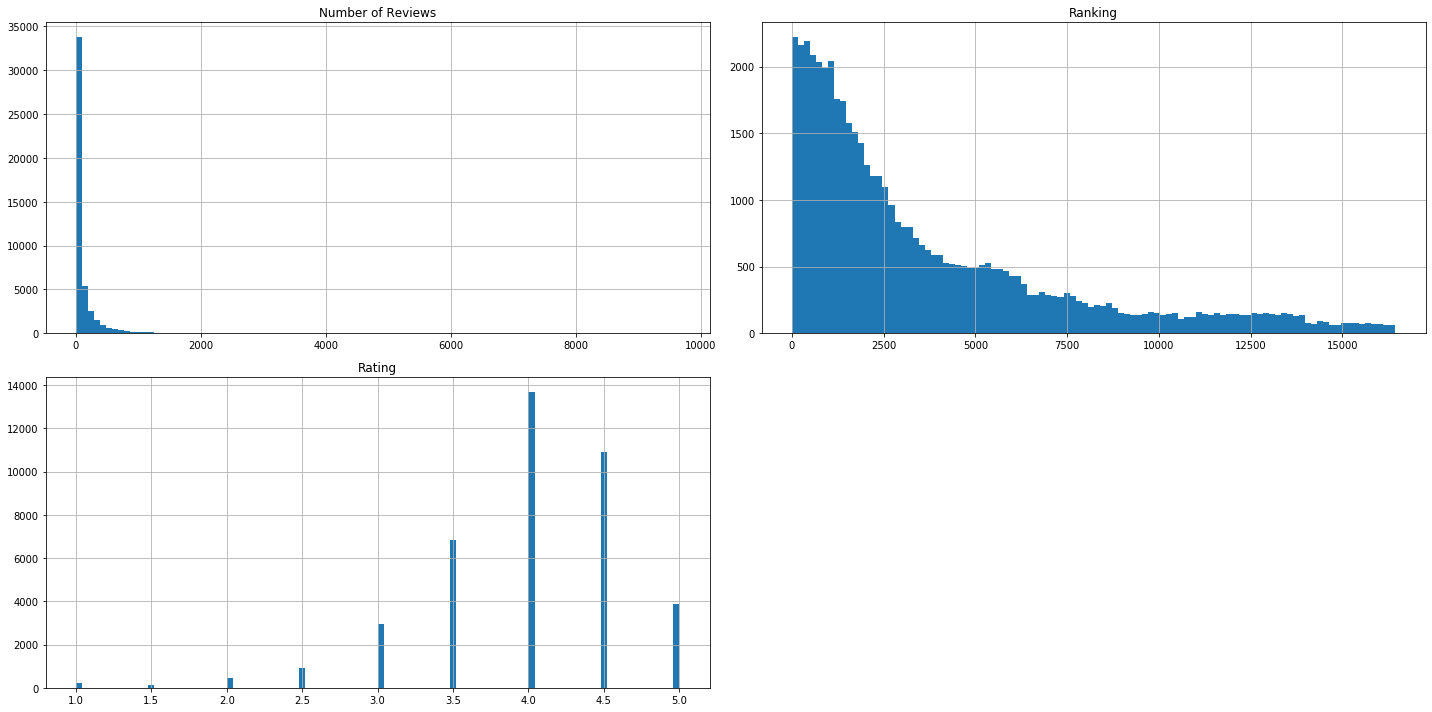

In [325]:
df[['Ranking', 'Rating', 'Number of Reviews', 'City', 'Price Range','Cuisine Style','Reviews','Restaurant_id',]].hist(figsize=(20, 10), bins=100);
plt.tight_layout()

In [326]:
population_city_dict = {}
country_city_dict = {}
# Получаем словари популяции по городам, а так же ISO код страны по городу
population_city_dict, country_city_dict = get_city_population_and_country()

In [327]:
# Вычисляем страну для города в каждой строке
df['Country'] = df["City"].apply(lambda x: country_city_dict[x])

In [328]:
# Вычисляем к-во ресторанов для города в каждой строке
restorants_in_city = df.groupby('City')['Ranking'].count().to_dict()
df['Restaurants Count'] = df['City'].map(restorants_in_city)

In [329]:
# Вычисляем население (в тыс. чел) для города в каждой строке
df['Population'] = df["City"].apply(lambda x: population_city_dict[x])

In [330]:
# Вычисляем к-во ресторанов на 1000 чел для города в каждой строке
df['Restaurants for Population'] =  df['Restaurants Count'] /(df['Population']*1000)

In [331]:
# Вычисляем является ли город столицей в каждой строке
capital_city_dict = get_capital_city_dict()
df['isCapital'] = df["City"].apply(lambda x: capital_city_dict[x])

In [332]:
# Не будем кодировать названия городов - get_dummies справится 
# df["City"] = df["City"].astype('category')
# #df["City"] = df["City"].cat.codes
# encoder = LabelEncoder()
# df['City'] = encoder.fit_transform(df['City'])

In [333]:
# Получаем относительную позицию ресторана среди всех ресторанов города
df['Weighed Rank'] = df.apply(lambda x: get_Weighed_Rank_RK(x), axis=1)


In [334]:
# Перекодируем Price Range и удаляем NaN
cleanup_nums = {'Price Range':     {"$": 1, "$$ - $$$": 2, "$$$$": 3, np.NaN: 2}} # чаще всего встречается "$$ - $$$" == 2
df['Price Range NAN'] = df['Price Range'].isna()
df.replace(cleanup_nums, inplace=True)

In [335]:
# Получаем Cuisines Count, самую популярную кухню, среднее к-во кухонь в ресторане
df['Cuisine Style'] = df['Cuisine Style'].fillna('NaN')
df['Cuisines Count'] = df.apply(cuisine_styles_count, axis=1)

most_popular_cusine = pd.Series(allCusines).value_counts().index[0]
average_cousines_count = np.round(df['Cuisines Count'].mean(),1)

In [336]:
# Флаги (1/0) isMostPopCusine - есть ли в ресторане самая популярная кухня; isMultyCusine - к-во кухонь в ресторане больше или столько же чем в среднем
df['isMostPopCusine'] = df['Cuisine Style'].apply(lambda x: 1 if most_popular_cusine in x else 0 )
df['isMultyCusine'] = df['Cuisines Count'].apply(lambda x: 1 if  x >= average_cousines_count else 0 )

In [337]:
# Reviews - убираем NaN и "причесываем" текст отзывов 
df['Reviews'] = df['Reviews'].fillna('[[], []]')
df['Reviews'] = df['Reviews'].apply(lambda x: cleanup_string(x))

In [338]:
# RevTimeDelta - время между review в днях

df['RevTimeDelta'] = df['Reviews'].apply(rev_time_delta)

In [339]:
# NewestReviewDate - время, прошедшее со момента последнего review до '22/02/2020'
df['NewestReviewDate'] = df['Reviews'].apply(lambda x: get_reviews(x)['reviews_dt'])
df['NewestReviewDate'] = df['NewestReviewDate'].apply(lambda x: sorted(x,reverse=True)[0] if len(x)!=0 else pd.NaT)
df['NewestReviewDate'] = df['NewestReviewDate'].fillna(dt.date(1970,1,1))
df['NewestReviewDate'] = df['NewestReviewDate'].apply(lambda x: (CURRENT_DATE.date()-x).total_seconds()//86400)

In [340]:
#  'TxtReviewsCount' - к-во отзывов, не сильно улучшает результат, но пусть будут
df['TxtReviewsCount'] = df['Reviews'].apply(lambda x: len(get_reviews(x)['reviews_txt']))

In [341]:
# Устраняем выбросы - только ухудшает резульата
#fix_outliers()

In [342]:
# зависимость места ресторана в городе от населения
df['Weighed Rank by Population'] = df['Weighed Rank']  / df['Population'] 
#df['Weighed Rank by Population'] = df['Weighed Rank'] * df['Population']

In [343]:
# Принимаем, что пропущенные - это рестораны из самой популярной категории ($$-$$$)
# Регистрируем NaN
df['Number of Reviews NAN'] = df['Number of Reviews'].isna()
replace_val = df[df['Price Range'] == 2]['Number of Reviews'].mean()
replace_val =np.round(replace_val)
df['Number of Reviews'] = df['Number of Reviews'].fillna(replace_val)


---
# Устранили NaN и сгенерили новые признаки, посмотрим какие из них подходят  

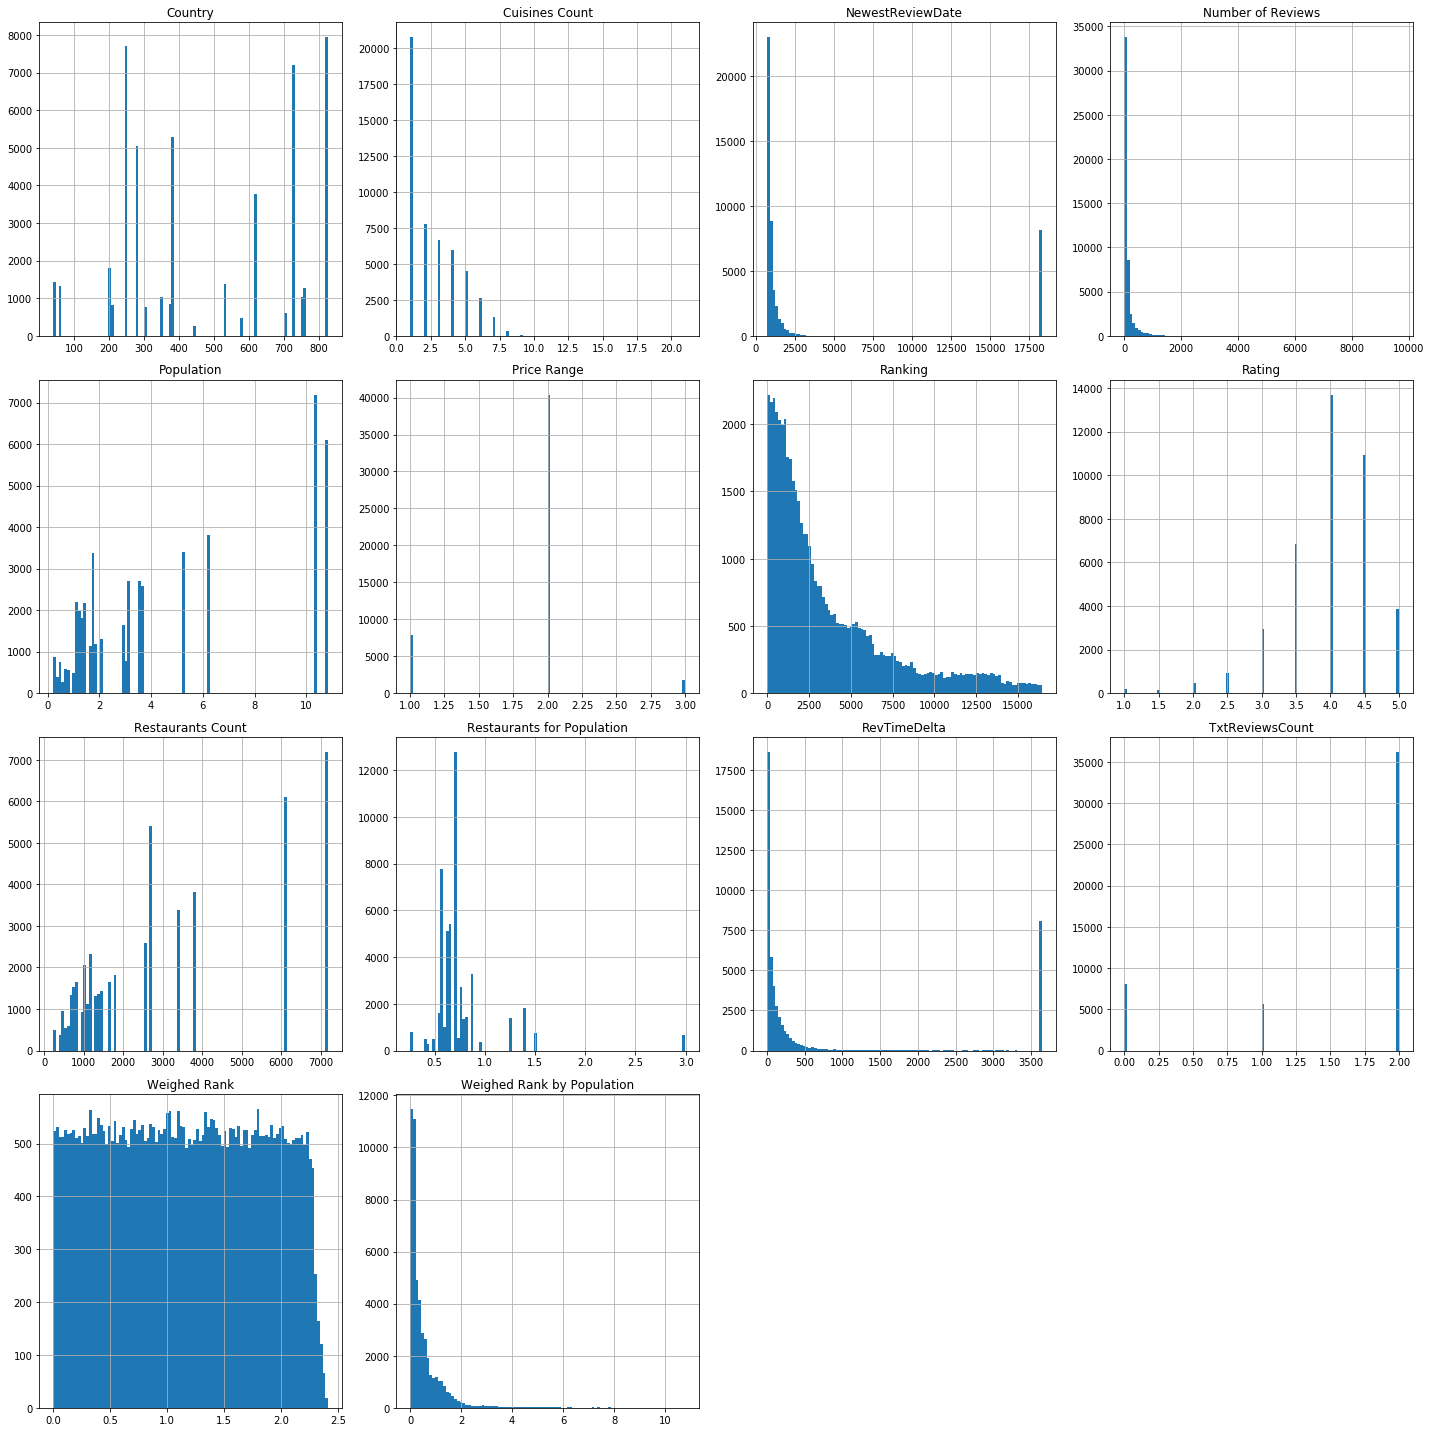

In [344]:

df[['Ranking', 'Rating', 'Number of Reviews', 'City', 'Price Range',
        'Restaurant_id',  'Country',
       'Restaurants Count', 'Population', 'Restaurants for Population',
       'Weighed Rank',  'Cuisines Count',
       'RevTimeDelta', 'NewestReviewDate',
       'TxtReviewsCount', 'Weighed Rank by Population']].hist(figsize=(20, 20), bins=100);
plt.tight_layout()

In [345]:
# Сокращаем список кухонь для анализа до N - основных, остальные Other
# Регистрируем NaN
N=40 #!!!
df['Cuisine Style NAN'] = df['Cuisine Style'].isna()
s = df['Cuisine Style'].apply(lambda x: get_cuisines(x))
slist =[]
for x in s:
    slist.extend(x)
topNcusines = set(pd.Series(slist).value_counts()[:N].index)  
df['Cuisine top N'] =df['Cuisine Style'].apply(lambda x: is_cuisine_top_N(x))

In [346]:
# Сетевой ID ресторана (похоже, что это ID франшизы, если повторяется более 1-го раза - isNetworkRestorant)
# 'isNetworkRestorant' - не улучшает результат НЕ включаем в набор признаков
# df['Restaurant_net_id'] = df['Restaurant_id'].apply(lambda x: x.split('_')[1])
# NetworkRestorants = df[df['Restaurant_net_id'].isin(df['Restaurant_net_id'].value_counts()[df['Restaurant_net_id'].value_counts()>2].index)]
# NetworkRestorants['isNetworkRestorant'] = True
# df['isNetworkRestorant'] = NetworkRestorants['isNetworkRestorant']
# df['isNetworkRestorant'] = df['isNetworkRestorant'].fillna(False)

In [347]:
#Построим корреляции (City временно закодировали)
df_tmp = df[df.ForTrain][['Ranking', 'Rating', 'Number of Reviews', 'City', 'Price Range',
        'Restaurant_id',  'Country',
       'Restaurants Count', 'Population', 'Restaurants for Population',
       'isCapital', 'Weighed Rank', 'Price Range NAN', 'Cuisines Count',
       'isMostPopCusine', 'isMultyCusine', 'RevTimeDelta', 'NewestReviewDate',
       'TxtReviewsCount', 'Weighed Rank by Population',
        'Cuisine top N']]
df_tmp["City"] = df_tmp["City"].astype('category')
encoder = LabelEncoder()
df_tmp['City'] = encoder.fit_transform(df_tmp['City'])


# Посмотрим на корреляцию в виде heatmap  

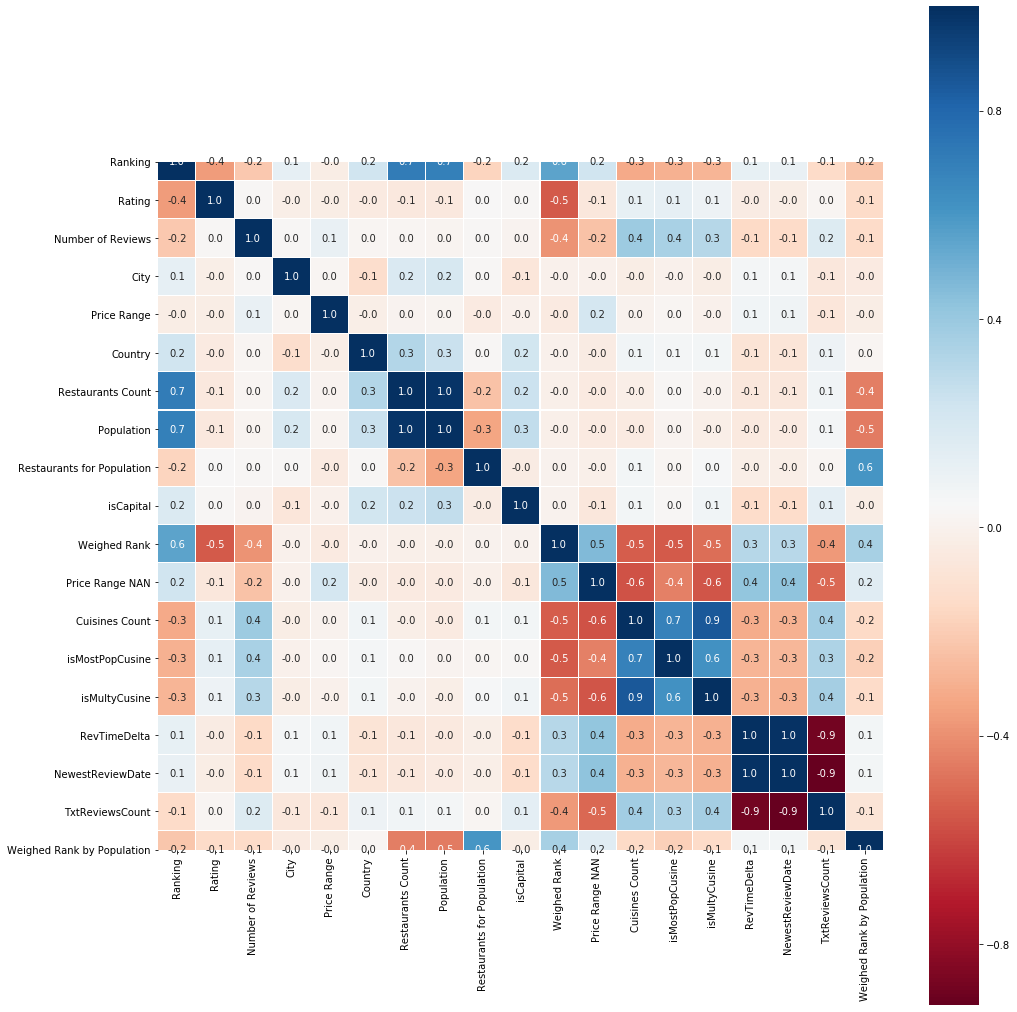

In [348]:
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(df_tmp.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()


In [349]:
# Собираем Dummies: city, price_range, ountry_range, Cuisine top N

dff = pd.get_dummies(df['Cuisine top N'].apply(pd.Series).stack()).sum(level=0)
df_city = pd.get_dummies(df['City'], prefix = 'City Range',drop_first=True)
df_price_range = pd.get_dummies(df['Price Range'], prefix = 'Price Range',drop_first=True) 
df_country_range = pd.get_dummies(df['Country'], prefix = 'Country Range',drop_first=True) 


df1 = pd.concat([df,dff], axis=1)
df1 = pd.concat([df1,df_city], axis=1)
df1 = pd.concat([df1,df_price_range], axis=1)
df1 = pd.concat([df1,df_country_range], axis=1)


cols_cuisine_style = dff.columns
cols_city = df_city.columns
cols_price_range =  df_price_range.columns
cols_country_range =  df_country_range.columns


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [350]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)

columns = ['Number of Reviews',    'RevTimeDelta', 'NewestReviewDate',  'Population',  'Weighed Rank by Population',    'isMultyCusine',  'Restaurants for Population' ,   'Price Range NAN', 'Cuisine Style NAN', 'Number of Reviews NAN' , 'Weighed Rank', 'Cuisines Count', 'Restaurants Count', 'TxtReviewsCount', ] #'Price Range',



columns.extend(cols_cuisine_style.tolist())
columns.extend(cols_country_range.tolist())
columns.extend(cols_city.tolist())
columns.extend(cols_price_range.tolist())


X = df1[df1.ForTrain][columns]

y = df1[df1.ForTrain]['Rating']

In [351]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [352]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 20% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

---
# Создаём, обучаем и тестируем модель

In [353]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [354]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
 
# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [355]:
# y_pred округляем до 0.5 - т.к. Raiting - имеет шаг 0.5
y_pred = round_of_rating(y_pred)  

---

In [356]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1695625


----

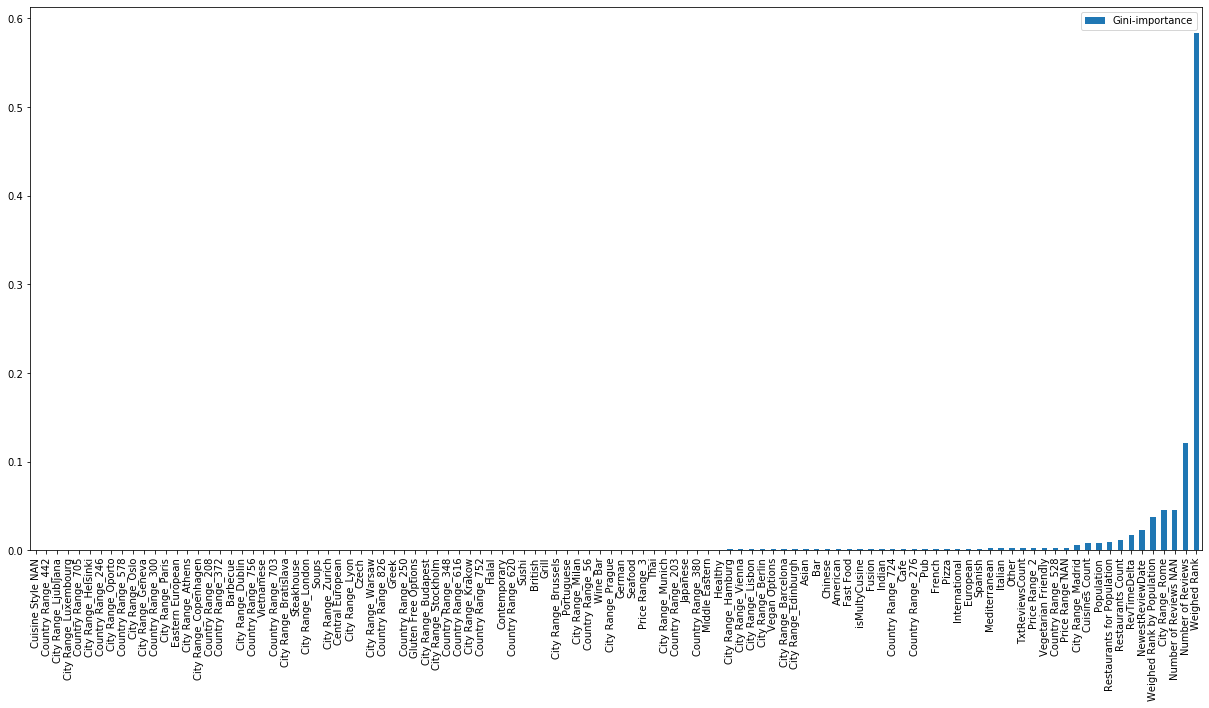

In [357]:
# Значимость признаков
feats = {} # словарь feature_name: feature_importance
for feature, importance in zip(X.columns, regr.feature_importances_):
    feats[feature] = importance 
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})

importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(21, 10));

In [358]:
# Предсказываем рейтинги на датасете для предсказаний (ForTrain == False)
X_submission = df1[df1.ForTrain == False][columns]
y_pred_submission = round_of_rating(regr.predict(X_submission))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [359]:
# Формируем датасет с предсказаниями Restaurant_id -- Rating
submission_df = pd.DataFrame()
submission_df['Restaurant_id'] = df1[df1.ForTrain == False]['Restaurant_id']
submission_df['Rating'] = y_pred_submission
submission_df

,Restaurant_id,Rating
40000,id_0,3.0
40001,id_1,4.5
40002,id_2,4.5
40003,id_3,4.5
40004,id_4,4.5
...,...,...
49995,id_9995,4.5
49996,id_9996,4.5
49997,id_9997,3.0
49998,id_9998,4.5


In [360]:
# Сохраняем предсказания
submission_df.to_csv(submission_path, index=False)

-----------------
# Проверяем годность предсказаний  
Распределения достаточно похожи - ОК!


In [361]:
print('Тренировочный датасет')
df[df.ForTrain].Rating.value_counts()


Тренировочный датасет


4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64

In [362]:
print('Предсказания масштабированные в 4 раза')
submission_df.Rating.value_counts()*4

Предсказания масштабированные в 4 раза


4.0    15116
4.5    11172
3.5     6556
5.0     2960
3.0     2788
2.5      772
2.0      364
1.0      156
1.5      116
Name: Rating, dtype: int64